# Global Terrorism DataSet Analysis: 

Data:
    - Where from?
    - Items
    - Scope
    - Contributors

Goals:
    - ...


In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.collections as mcol
#use this style of plots
plt.style.use('ggplot') 
#print plots in notebook
%matplotlib inline 

import sklearn as sk
from sklearn.cluster import *
from sklearn.preprocessing import OneHotEncoder

In [2]:
def convert_eventid_to_datetime(df, ignore_bad_data=True):
    """Converts dataframe with event_id column to date time formats. Returns new DF with additional 'datetime' column."""
    from datetime import datetime
    
    datetime_series = []
    ix_to_drop = []
    count = 0
    for i, row in df.iterrows():
        try:
            year = int(row['iyear'])
            month = int(row['imonth'])
            day = int(row['iday'])
            datetime_series.append( datetime(year, month, day) )
        except:
            ix_to_drop.append(count)
            if not ignore_bad_data:
                print("Bad Event ID date format: {}, {}, {}. Event ID: {}"
                      .format(year, month, day, row['eventid']) )
                raise ValueError('Event Id data contains bad dates.')
        count += 1
        
    print('Dropped {} malformed event id rows out of {}.'.format(len(ix_to_drop), df.shape[0]))
    df = df.drop(df.index[ix_to_drop])
    df['datetime'] = pd.to_datetime(datetime_series)
    
    return df

## Read in and sub-sample data

1. Read in dataframe, specifying subset of columns
2. Optionally sub-sample data to manageable size

In [59]:
#read in the data file and make into a pandas dataframe: location, only specific columns
original_df = pd.read_csv('./inputs/globalterrorismdb.csv', encoding='ISO-8859-1', usecols=['eventid', 'iyear', 'imonth', 'iday', 'country', 'region', 
                         'latitude', 'longitude', 'crit1', 'crit2', 'crit3', 'attacktype1','targtype1','targsubtype1','weaptype1',
                          'weapsubtype1'],
                         dtype={'iyear':'int', 'imonth':'int', 'iday':'int'});

#use a manageable sample size
num_rows = 10000
#shows the size of the original data
# print('Original shape of CSV: {}'.format(original_df.shape))

# DropNA() is dropping all NaN values from the dataset. Talk about potential bias. Investigate what causes this bad data.
#Free up memory by deleting the unused origial data
terrorism_df = original_df.dropna().sample(n=num_rows)
del original_df
print(type(terrorism_df))

#displays the columns being used
print(terrorism_df.columns)

# Convert known event times to timestamp column
datetime_df = convert_eventid_to_datetime(terrorism_df, ignore_bad_data=True)    
print(datetime_df.shape)

terrorism_df = datetime_df
del datetime_df


<class 'pandas.core.frame.DataFrame'>
Index(['eventid', 'iyear', 'imonth', 'iday', 'country', 'region', 'latitude',
       'longitude', 'crit1', 'crit2', 'crit3', 'attacktype1', 'targtype1',
       'targsubtype1', 'weaptype1', 'weapsubtype1'],
      dtype='object')
Dropped 34 malformed event id rows out of 10000.
(9966, 17)


## Scatter Plots 
Can see how some of the data may be realted based on scatter plots generated:
    1. Latitude vs Longitude shows us the location of attacks. 
        *Could underlay a map to get a better visual if wanted.    

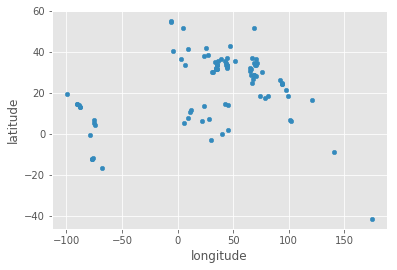

In [4]:
# terrorism_df['iyear']
#print(terrorism_df.shape)
# print(terrorism_df.columns)

year_lat_df = terrorism_df[0:100][['latitude', 'longitude']]

year_lat_df.plot.scatter(x='longitude',y='latitude')

### Testing clustering on Latitude and Longitude
      1. Use K-means algorthim to cluster points to two groups based on "closeness"
      2. Use colormap to view the different clusters

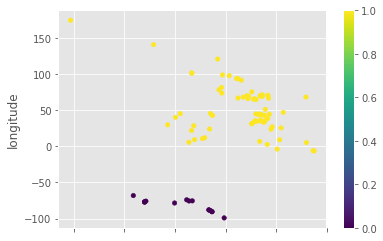

In [5]:
from sklearn.cluster import KMeans

cl = sk.cluster.KMeans(n_clusters=2).fit(year_lat_df)

year_lat_df.plot.scatter(x='latitude',y='longitude', c=cl.labels_, colormap='viridis')

### One hot encoding

One hot encoding deals with our categorical variables by creating an <em>n-dimensional</em> row vector per category.

* Specify columns
* Get dummy variables
    * Optionally append to previous dataframe

In [6]:
#create new data frame with the dummy variables included
t_dummies_df = pd.get_dummies(terrorism_df, columns=['weaptype1', 'region'], dtype=bool)


### Pair Plots

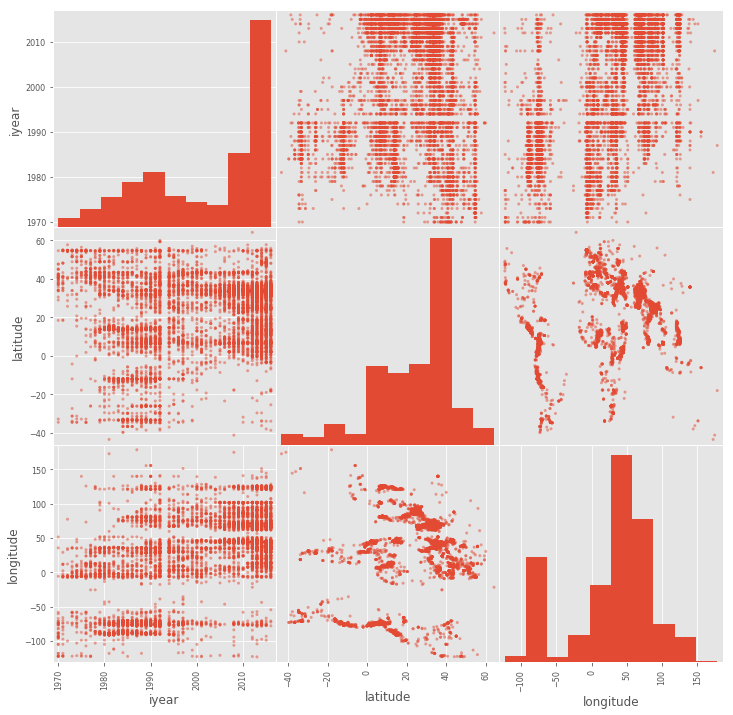

In [7]:
#Plots each variable with each other and displays a matrix of different plots
scatter_matrix(terrorism_df[['iyear', 'latitude', 'longitude']], figsize=(12, 12))
plt.show()

# Data Exploration
    Questions:
        1. Is there a certain time during the year that attacks are more frequent?
    

### Subsection 1: Time of Year

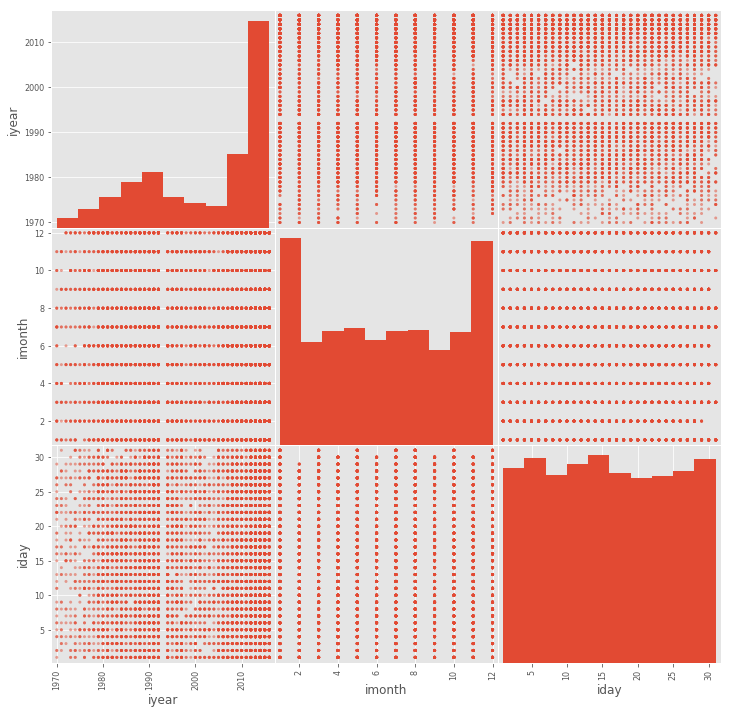

In [39]:
#View plot of months over years to see if any common/uncommon attack months
#scatter_matrix(terrorism_df[['iyear', 'imonth', 'iday']], figsize=(12, 12))
#scatter_matrix(terrorism_df[['region']], figsize=(12, 12))
#plt.show()

#Create a encoding that makes true/false columns for each month
#months_region_dummies_df = pd.get_dummies(terrorism_df, columns=['region'], dtype=bool)




#### Line plot of Global Monthly Trend


In [86]:
# Line plot of events over time
# grouped_terr_df = terrorism_df.groupby(['datetime']).count()

datetime_df = terrorism_df.set_index('datetime')

start_date = '1970-01-1'
end_date = '2017-01-01'

# daily_terr_df = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='D')).count()
monthly_terr_df = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='M')).count()

monthly_terr_df.iloc[0:]

#daily_terr_df['eventid'].plot(kind='line', figsize=[30,5])
#monthly_terr_df['eventid'].plot(kind='line', figsize=[30,5])

# fig, ax = plt.subplots(figsize=(15,7))
# .groupby(['date','type']).count()['amount'].plot(ax=ax)


#####################################################################################################
# ADDED COLUMN FOR REGION 10 SUM FOR EASY PLOTTING
# monthly_terr_df['region_10_sum'] = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='M'))['region_10'].sum()
# monthly_terr_r_10_df = [start_date:end_date].groupby(pd.Grouper(freq='M')).count()
# monthly_terr_df['region_10_sum'].plot(kind='line', figsize=[25,10])
# monthly_terr_df.iloc[0:20]

# region_10_df.plot(kind='line', figsize=[30,5])
# plt.savefig('./terr_event_date.png')
# region_10_df / monthly_terr_df['']
# ratio = region_10_df[''] / monthly_terr_df
# monthly_terr_df.plot(x=monthly_terr_df.index, y='region_10_sum', kind='line', figsize=[25,5])
#######################################################################################################

,eventid,iyear,imonth,iday,country,region,latitude,longitude,crit1,crit2,crit3,attacktype1,targtype1,targsubtype1,weaptype1,weapsubtype1
datetime,,,,,,,,,,,,,,,,
1970-01-31,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1970-02-28,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1970-03-31,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1970-04-30,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1970-05-31,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1970-06-30,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1970-07-31,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1970-08-31,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1970-09-30,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


### Global Monthly Trend
    Our graph above shows a possible global monthly trend for attack occurances. I am going to start exploring possible
    reasons for the frequency of attacks in Jan and Dec. 


#### Scatter Plot of Jan and Dec dataframe to look for possible Region differences

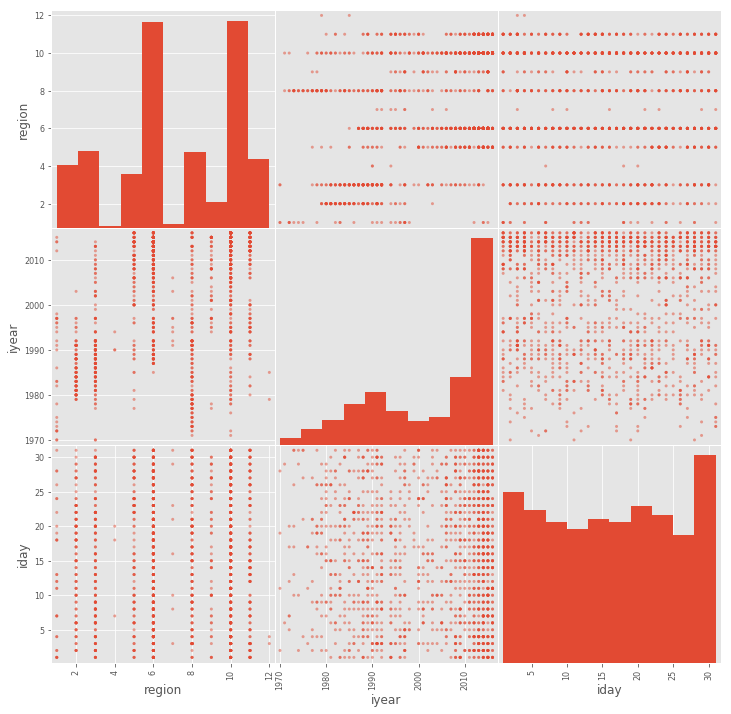

In [67]:
#Make new dataframe with only months of Jan and Dec
DecJan_terrorism_df = terrorism_df[((terrorism_df['imonth']== 1) | (terrorism_df['imonth'] == 12))]
#DecJan_terrorism_df = terrorism_df[(terrorism_df['iyear']>2011) & ((terrorism_df['imonth']== 1) | (terrorism_df['imonth'] == 12))]
scatter_matrix(DecJan_terrorism_df[['region', 'iyear', 'iday']], figsize=(12, 12))
plt.show()

#DecJan_terrorism_df.iloc[0:]

#year_lat_df = DecJan_terrorism_df[0:100][['latitude', 'longitude']]
#year_lat_df.plot.scatter(x='longitude',y='latitude')

#### Removing Regions
Region 6 and 10 account for over half the number of attacks. Will removing these regions effect our monthly trend? 

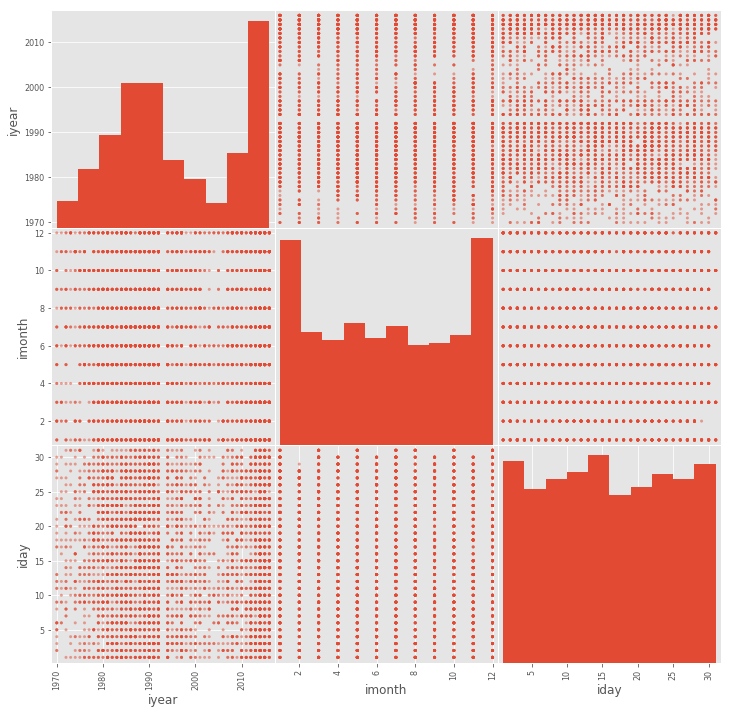

In [66]:
#make a new dataframe removing region 10 & 6:
region_df = terrorism_df[((terrorism_df['region'] != 10) & (terrorism_df['region'] !=6))]

scatter_matrix(region_df[['iyear', 'imonth', 'iday']], figsize=(12, 12))
plt.show()

#region_df.iloc[0:]

### Line Plot for Each Region's monthly attacks

##### Observations
* 

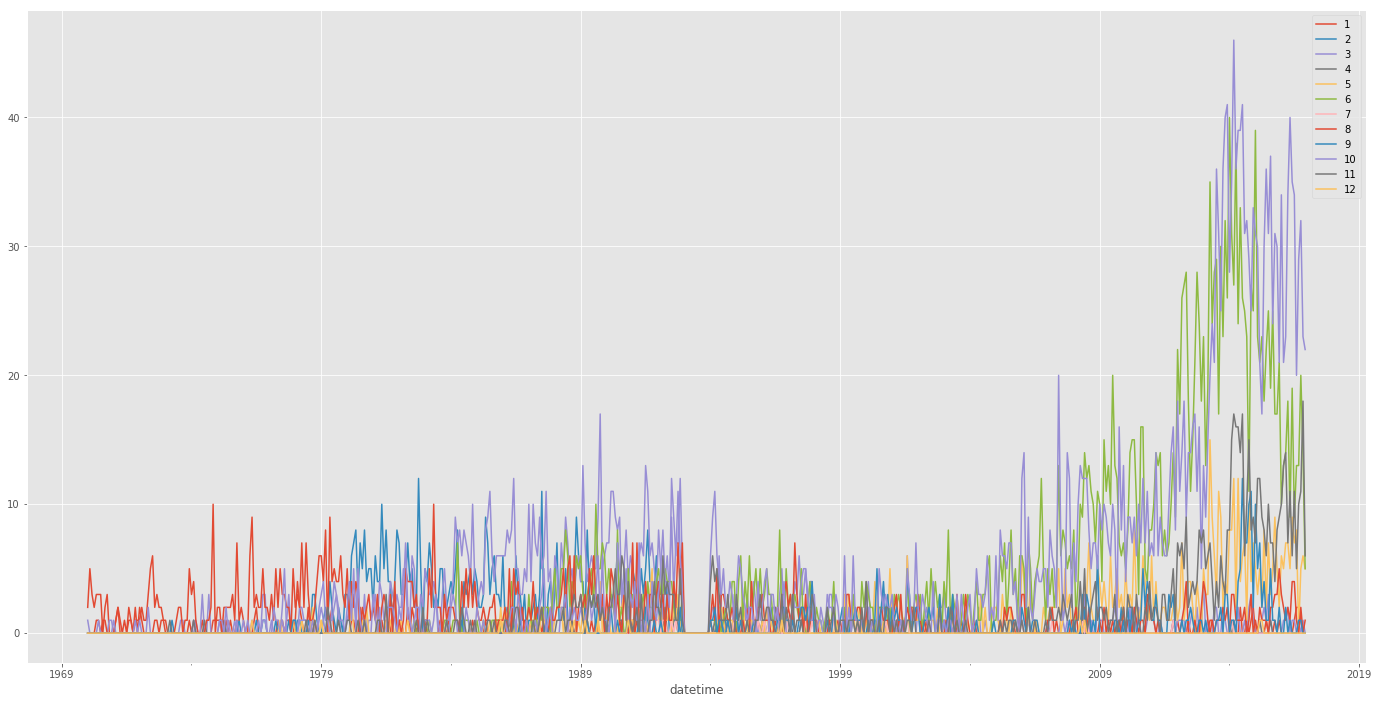

In [123]:
#Plot monthly trend for each region

regional_dummies = pd.get_dummies(datetime_df['region'])
regional_dummies.groupby(pd.Grouper(freq='M')).sum().plot(kind='line', figsize=[24,12] )

## Results
    There does not appear to be a large difference among Regions. 